<a href="https://colab.research.google.com/github/itssofiarce/AA1-TUIA-Petetta-Arce/blob/sofi_main/TP_integrador_AA1_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# De scikit-learn...

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# Estandarización y modelado
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_selector
# Division de los datos
from sklearn.model_selection import train_test_split

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Regresiones
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression

# ML metricas
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
path= '/content/drive/MyDrive/weatherAUS.csv'
df = pd.read_csv(path, usecols=range(1,25))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [4]:
### Busco duplicados
if not df.duplicated().any():
  print('No hay registros duplicados')

No hay registros duplicados


In [5]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Date'], axis=1)

In [6]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    costa_este = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    X.loc[X['Location'].isin(costa_este), 'Location'] = 'costa_este'
    return X[X['Location'] == 'costa_este']

In [7]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [8]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [9]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [10]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [11]:
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

In [12]:
class BoolYNDropperEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X.dropna(subset=['RainToday'], inplace=True)
      X['RainTomorrow'] = X['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(float)
      X['RainToday'] = X['RainToday'].map({'No': 0, 'Yes': 1}).astype(float)

      return X

In [13]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday', 'RainTomorrow']#, ,'Canberra','Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [14]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X


In [15]:
class RLValDropper(BaseEstimator, TransformerMixin):
  def fit (self, X, y=None):
    return self
  def transform(self, X):
    X.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
    return X


In [16]:
preprocessor = Pipeline([
     ('drop_null_val_rl', RLValDropper()),
     ('drop_not_needed_features', ColDropper()),
     ('drop_nor_needed_locations',LocDropper()),
     ('yes_no_dropper_encoder', BoolYNDropperEncoder()),
     ('fill_null_cat', CatFiller()),
     ('fill_num_cat', NumFiller()),
     ('encode_loc', LocEncoder()),
     ('encode_wind_dir', CoordRecat()),
     ('reset_index',ResetIndex()),
     ('treat_outliers',OutliersTreater()),
     ('standariza_values', Standarizer())
])


# Train-Test split

In [17]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainTomorrow'], axis=1).copy()
y = df[['RainTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((116329, 23), (29083, 23), (116329, 1), (29083, 1))

In [18]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainTomorrow'] = y['RainTomorrow']

In [19]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainTomorrow'] = y['RainTomorrow']

In [20]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

# Balanceo de datos

In [21]:
# Modulos para el balanceo
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [22]:
def plot_balance(df):
  ### Balance de datos:
  rain_classes = pd.value_counts(df['RainTomorrow'], sort = True)
  rain_classes.plot(kind = 'bar', rot=0)
  plt.xticks(range(2))
  plt.title("Frecuencia")
  plt.xlabel("RainTomorrow")
  plt.ylabel("Cantidad")
  X_train_resampled=df.drop(['RainTomorrow'], axis=1)
  y_train_resampled=df['RainTomorrow']
  print(X_train_resampled.shape, y_train_resampled.shape)
  plt.show()


In [23]:
# Helper function for plotting ROC -- > https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr,tpr,label=f"{title} AUC={auc:.3f}")
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)

Una vez hecho el split entre train y test, verificamos que el dataset esté balanceado.

(145412, 23) (145412,)


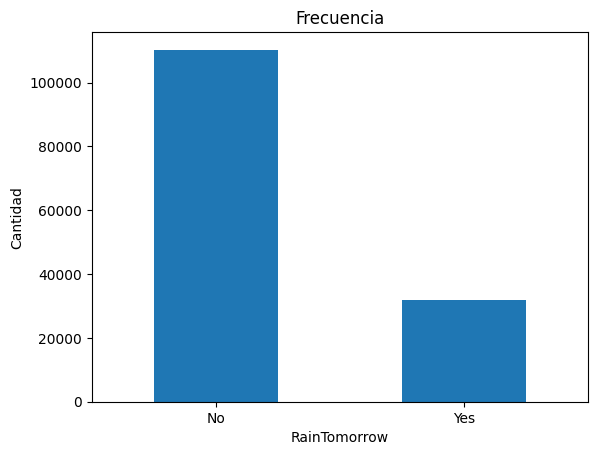

In [24]:
plot_balance(df)

En el gráfico de arriba se puede ver como en el dataframe original la cantidad de muestras para los dias de lluvia son mucho menor que la de los días que no llovieron.

(19226, 25) (19226,)


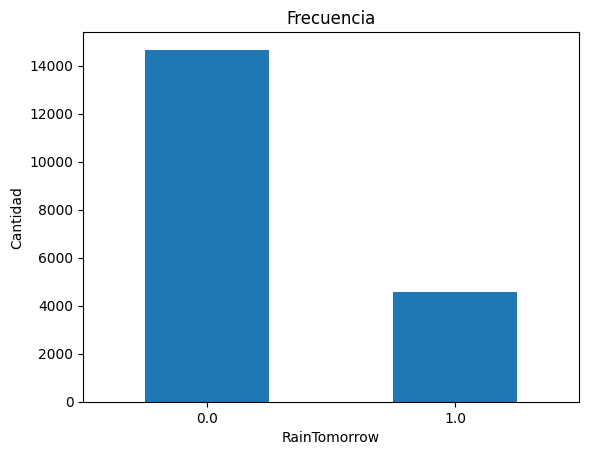

In [25]:
plot_balance(df_train)

De las 10000 muestras en el dataset original con datos de toda Australia, quedaron alrededor de 19000 pertenecientes a la costa este australiana.

Comparamos con AUC que técnica de balanceo de datos es mejor para la regresión logística

In [26]:
# Separación de variables explicativas y variables objetivo
X_train_balance = df_train.drop(['RainTomorrow'], axis=1).copy()
y_train_balance = df_train['RainTomorrow'].copy()

X_test_balance = df_test.drop(['RainTomorrow'], axis=1).copy()
y_test_balance = df_test['RainTomorrow'].copy()

In [27]:
X_train_balance.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow', 'costa_este',
       'WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin',
       'WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos', 'RainToday'],
      dtype='object')

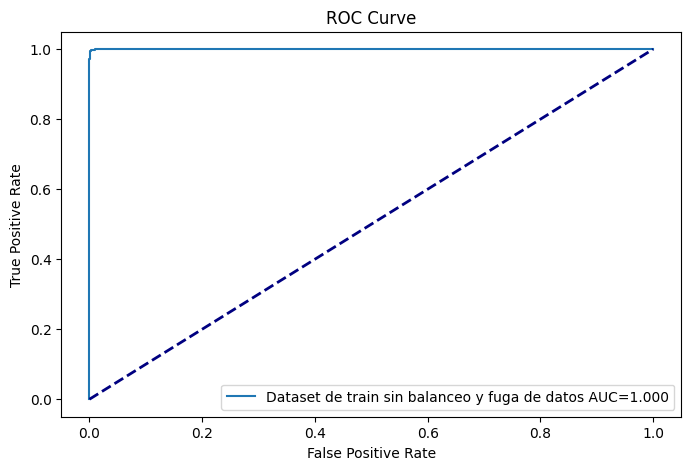

In [49]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_balance, y_train_balance, X_test_balance, y_test_balance, 'Dataset de train sin balanceo y fuga de datos')

Se puede ver como el modelo ajusta perfectamente cuando se usa el dataset completo incluso sin balancear. La razón de esto es que el modelo tiene fuga de datos porque en el Dataset existe 'RainfallTomorrow'. Por eso para elegir el mejor método de balanceo de datos para la regresión logística vamos a droppear de nuestro Dataset ya balanceado a 'RainfallTomorrow'.

#### - Balanceo con Oversampling

In [29]:
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train_balance, y_train_balance)

In [30]:
df_ros = pd.DataFrame(X_train_ros, columns=X_train_balance.columns)
df_ros['RainTomorrow'] = y_train_ros

(29328, 25) (29328,)


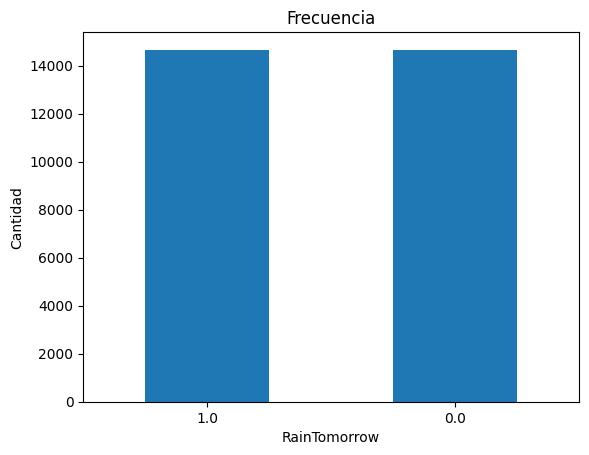

In [31]:
plot_balance(df_ros)

Con el sobremuestreo, la clase minoritaria ahora tiene igual cantidad de muestras que la clase mayoritaria. Teniendo como resultado un data frame de testeo de 29000 muestras

#### - Balanceo con Undersampling

In [32]:
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train_balance, y_train_balance)

In [33]:
df_rus = pd.DataFrame(X_train_rus, columns=X_train_balance.columns)
df_rus['RainTomorrow'] = y_train_rus

(9124, 25) (9124,)


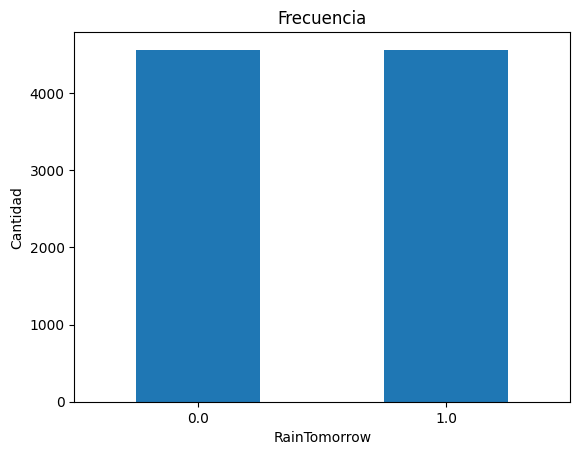

In [34]:
plot_balance(df_rus)

Con el submuestreo, la clase mayoritaria ahora tiene igual cantidad de muestras que la clase minoritaria. Teniendo como resultado un data frame de testeo de alrededor de 8000 muestras

#### - Balanceo con SMOTE


In [35]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_balance, y_train_balance)

In [36]:
df_SMOTE = pd.DataFrame(X_train_smote, columns=X_train_balance.columns)
df_SMOTE['RainTomorrow'] = y_train_smote

(29328, 25) (29328,)


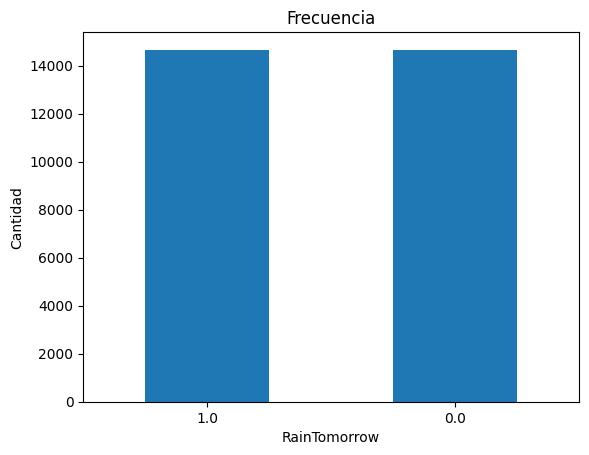

In [37]:
plot_balance(df_SMOTE)

#### - Balanceo con SMOTE(oversampling)-TOMEK(undersampling)

In [50]:
smotetomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_balance, y_train_balance)

In [39]:
df_smotetomek = pd.DataFrame(X_train_smotetomek, columns=X_train_balance.columns)
df_smotetomek['RainTomorrow'] = y_train_smotetomek

(29236, 25) (29236,)


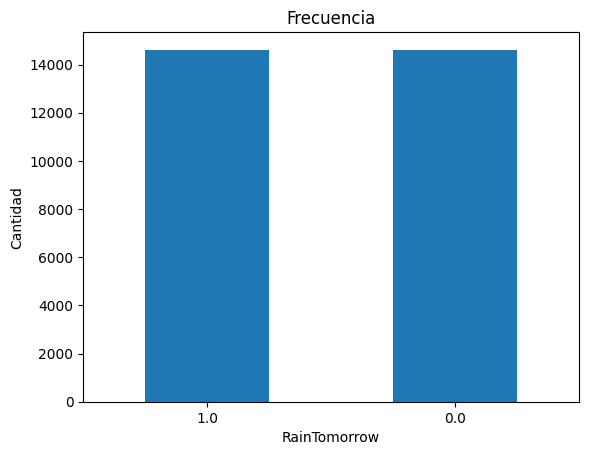

In [40]:
plot_balance(df_smotetomek)

In [ ]:
# Plot all ROC into one graph , y_train_balance
fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_balance, y_train_balance, X_test_balance, y_test_balance, 'Dataset de train sin balanceo, con fuga')
plot_roc(ax, X_train_smote, y_train_smote, X_test_balance, y_test_balance, 'SMOTE Dataset con fuga')

fig,ax1 = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax1, X_train_ros.drop(['RainfallTomorrow'], axis=1), y_train_ros, X_test_balance.drop(['RainfallTomorrow'], axis=1), y_test_balance, 'Random Sobresampleo')
plot_roc(ax1, X_train_rus.drop(['RainfallTomorrow'], axis=1), y_train_rus, X_test_balance.drop(['RainfallTomorrow'], axis=1), y_test_balance, 'Random Subsampleo')
plot_roc(ax1, X_train_smote.drop(['RainfallTomorrow'], axis=1), y_train_smote, X_test_balance.drop(['RainfallTomorrow'], axis=1), y_test_balance, 'SMOTE Dataset')
plot_roc(ax1, X_train_smotetomek.drop(['RainfallTomorrow'], axis=1), y_train_smotetomek, X_test_balance.drop(['RainfallTomorrow'], axis=1), y_test_balance, 'SMOTE-TOMEK Dataset')

Un dataset no balanceado pero con fuga de datos hace overfitting, al igual que un dataset balanceado (en el gráfico optamos por SMOTE) con fuga.

Podemos concluir que para este modelo (regresión logística) teniendo en cuenta todas las features, las diferentes técnicas de resampleo tienen valores muy parecidos y cercanos a uno lo que siginifica que el TPR (ratio de verdaderos positivos) es mas alto que el FPR (ratio de falsos positivos, es decir, dias de no lluvia como lluvia)  

# Evaluación


In [42]:
def plot_matrix_confusion(y_test, y_pred):
  # Calcular la matriz de confusión
  confusion_mat = confusion_matrix(y_test, y_pred)

  # Crear una figura y un eje para la matriz de confusión
  plt.figure(figsize=(4, 3))
  sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", linewidths=0.1, linecolor='blue', cbar=True)

  # Añadir etiquetas a los ejes y al gráfico
  plt.xlabel('Predicción')
  plt.ylabel('Verdaderos')
  plt.title('Matriz de Confusión')
  plt.xticks(np.arange(2) + 0.5, ['No', 'Sí'])
  plt.yticks(np.arange(2) + 0.5, ['No', 'Sí'])
  plt.show()

In [66]:
def train_test_with_balanced_df(df_train, df_test, model):
  X_train = df_train.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1).copy()
  y_train = df_train['RainTomorrow'].copy()

  X_test = df_test.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1).copy()
  y_test = df_test['RainTomorrow'].copy()

  my_model = model(random_state=42)
  my_model.fit(X_train, y_train)
  y_pred = my_model.predict(X_test)

  print(f"Resultados con: {model.__name__}\n")
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

  print(f"\n\nMatriz de confusión para: {model.__name__}")
  plot_matrix_confusion(y_test, y_pred)

  print(f"\n\nPuntaje para training vs test")
  print(f"Training: {my_model.score(X_train, y_train)}")
  print(f"Test: {my_model.score(X_test, y_test)}")


Resultados con: LogisticRegression

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85      3651
         1.0       0.53      0.77      0.62      1098

    accuracy                           0.79      4749
   macro avg       0.72      0.78      0.74      4749
weighted avg       0.83      0.79      0.80      4749

[[2893  758]
 [ 256  842]]


Matriz de confusión para: LogisticRegression


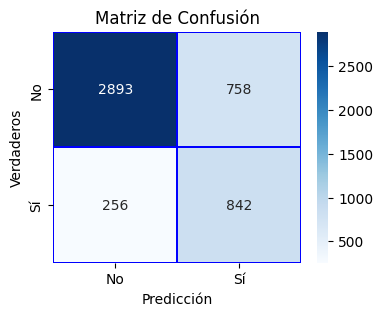



Puntaje para training vs test
Training: 0.7881546644844517
Test: 0.786481364497789


In [61]:
train_test_with_balanced_df(df_ros, df_test, LogisticRegression)

Hay overfitting porque mi modelo funciona un poco mejor para mi conjunto de train

# Testeo